In [196]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import pickle

In [197]:
DIRECTORY = 'data'
CATEGORIES = ['without_mask', 'with_mask'] # 0 : without_mask, 1 : with_mask

In [198]:
os.listdir(DIRECTORY)

['without_mask', 'with_mask']

In [199]:
IMG_SIZE = 100

data = []

for category in CATEGORIES:
  folder = os.path.join(DIRECTORY, category)
  label = CATEGORIES.index(category)
  for img in os.listdir(folder):
    if img.find('.png') >= 0 or img.find('.jpg') >= 0:
      img_path = os.path.join(folder, img)
      img_arr = cv2.imread(img_path)
      gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
      if gray.size >= IMG_SIZE * IMG_SIZE:
        gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        data.append([gray, label])
  

In [200]:
print('Size tập dữ liệu:', len(data))

Size tập dữ liệu: 3363


In [201]:
random.shuffle(data)

In [202]:
X = []
y = []

for features, labels in data:
  X.append(features)
  y.append(labels)
    
X = np.array(X)
y = np.array(y)

In [203]:
pickle.dump(X, open('X.pkl', 'wb'))
pickle.dump(y, open('y.pkl', 'wb'))

In [204]:
X = pickle.load(open('X.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))

In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

In [206]:
def display_images(images, labels):
        plt.figure(figsize=(10,10))
        grid_size = min(25, len(images))
        for i in range(grid_size):
                plt.subplot(5, 5, i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(images[i], cmap='gray')
                plt.xlabel(CATEGORIES[labels[i]])

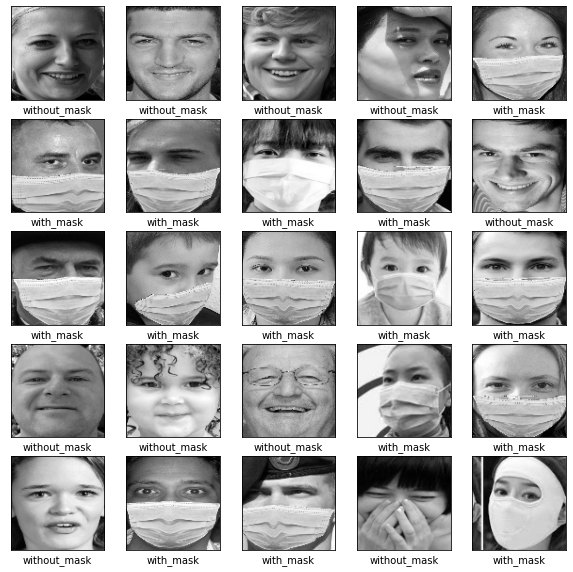

In [207]:
display_images(X_train, y_train)
plt.show()

In [208]:
X_train = X_train.reshape(X_train.shape[0], -1).T
y_train = y_train.reshape(1,-1)
X_test = X_test.reshape(X_test.shape[0], -1).T
y_test = y_test.reshape(1, -1)

In [209]:
m_train = X_train.shape[1]
m_test = X_test.shape[1]

print('Số lượng tập train:', m_train)
print('Số lượng tập test:', m_test)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

Số lượng tập train: 2690
Số lượng tập test: 673
X_train shape: (10000, 2690)
y_train shape: (1, 2690)
X_test shape: (10000, 673)
y_test shape: (1, 673)


In [210]:
X_train = X_train / 255
X_test = X_test / 255

In [211]:
X_train[0]

array([0.71764706, 0.27058824, 0.6       , ..., 0.68235294, 0.24705882,
       0.20392157])

In [212]:
def sigmoid(z):
  s = 1 / (1 + np.exp(-z))
  return s

In [213]:
def init_weight_bias(dim):
  w = np.zeros(shape=(dim, 1))
  b = 0
  return w, b

In [214]:
def safe_log(X):
  result = np.where(X > 0.0000000001, X, 0)
  np.log2(result, out=result, where=result > 0)
  return result

In [215]:
def propagate(w, b, X, Y):
  m = X.shape[1]

  A = sigmoid(np.dot(w.T, X) + b)
  cost = (-1/m) * np.sum(Y * safe_log(A) + (1 - Y) * (safe_log(1 - A)))

  dw = (1/m) * np.dot(X, (A-Y).T)
  db = (1/m) * np.sum(A - Y)

  cost = np.squeeze(cost)
  grads = {'dw': dw, 'db': db}

  return grads, cost

In [216]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
  costs =[]

  for i in range(num_iterations):
    grads, cost = propagate(w, b, X, Y)

    dw = grads['dw']
    db = grads['db']

    w = w - learning_rate * dw
    b = b - learning_rate * db

    if i % 100 == 0:
      costs.append(cost)

    if print_cost and i % 100 == 0:
      print('Cost after iteration %i: %f' % (i, cost))

  params = {'w': w, 'b': b}
  grads = {'dw': dw, 'db': db}

  return params, grads, costs


In [217]:
def predict(w, b, X):
  m = X.shape[1]

  Y_prediction = np.zeros((1, m))
  w = w.reshape(X.shape[0], 1)

  A = sigmoid(np.dot(w.T, X) + b)

  for i in range(A.shape[1]):
    Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0

  return Y_prediction

In [218]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):

    w, b = init_weight_bias(X_train.shape[0])
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    w = parameters['w']
    b = parameters['b']
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {'costs': costs,
         'Y_prediction_test': Y_prediction_test,
         'Y_prediction_train': Y_prediction_train,
         'w': w,
         'b': b,
         'learning_rate': learning_rate,
         'num_iterations': num_iterations}
    
    return d

In [219]:
d = model(X_train, y_train, X_test, y_test, num_iterations=30000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 1.000000
Cost after iteration 100: 0.785512
Cost after iteration 200: 0.718549
Cost after iteration 300: 0.679345
Cost after iteration 400: 0.651388
Cost after iteration 500: 0.629569
Cost after iteration 600: 0.611626
Cost after iteration 700: 0.596355
Cost after iteration 800: 0.583042
Cost after iteration 900: 0.571234
Cost after iteration 1000: 0.560624
Cost after iteration 1100: 0.550994
Cost after iteration 1200: 0.542184
Cost after iteration 1300: 0.534072
Cost after iteration 1400: 0.526563
Cost after iteration 1500: 0.519581
Cost after iteration 1600: 0.513062
Cost after iteration 1700: 0.506955
Cost after iteration 1800: 0.501217
Cost after iteration 1900: 0.495810
Cost after iteration 2000: 0.490702
Cost after iteration 2100: 0.485866
Cost after iteration 2200: 0.481278
Cost after iteration 2300: 0.476917
Cost after iteration 2400: 0.472763
Cost after iteration 2500: 0.468801
Cost after iteration 2600: 0.465015
Cost after iteration 2700: 0.461393
Cost

Cost after iteration 22500: 0.296822
Cost after iteration 22600: 0.296539
Cost after iteration 22700: 0.296257
Cost after iteration 22800: 0.295977
Cost after iteration 22900: 0.295698
Cost after iteration 23000: 0.295420
Cost after iteration 23100: 0.295143
Cost after iteration 23200: 0.294868
Cost after iteration 23300: 0.294594
Cost after iteration 23400: 0.294321
Cost after iteration 23500: 0.294050
Cost after iteration 23600: 0.293779
Cost after iteration 23700: 0.293510
Cost after iteration 23800: 0.293242
Cost after iteration 23900: 0.292975
Cost after iteration 24000: 0.292709
Cost after iteration 24100: 0.292444
Cost after iteration 24200: 0.292181
Cost after iteration 24300: 0.291919
Cost after iteration 24400: 0.291657
Cost after iteration 24500: 0.291397
Cost after iteration 24600: 0.291138
Cost after iteration 24700: 0.290880
Cost after iteration 24800: 0.290623
Cost after iteration 24900: 0.290367
Cost after iteration 25000: 0.290112
Cost after iteration 25100: 0.289859
C

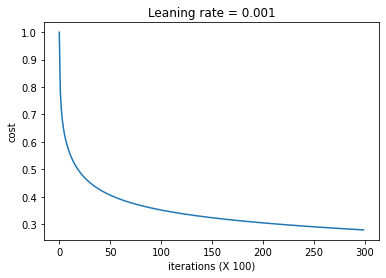

In [227]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (X 100)')
plt.title('Leaning rate = ' + str(d['learning_rate']))
plt.show()

In [229]:
def predict_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
    # plt.imshow(gray_test, cmap='gray')
    gray = gray.reshape(-1, 1)
    gray = gray / 255
    label = np.squeeze(predict(d['w'], d['b'], gray))
    return label


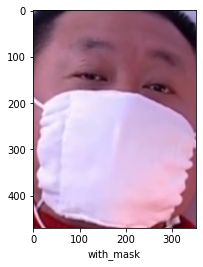

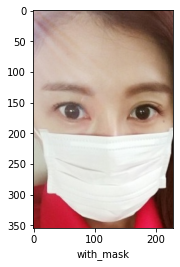

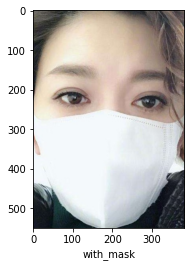

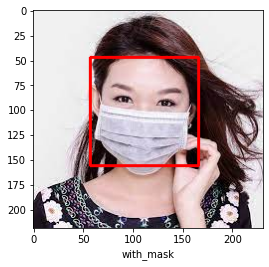

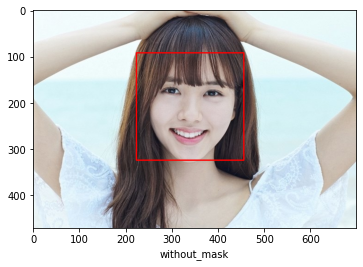

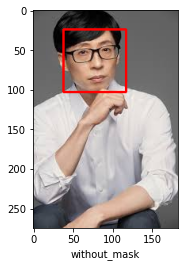

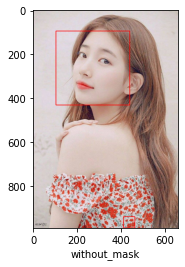

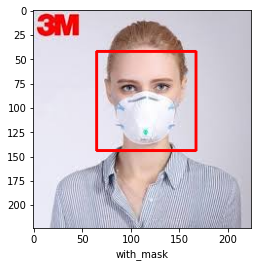

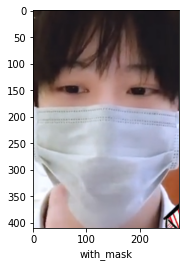

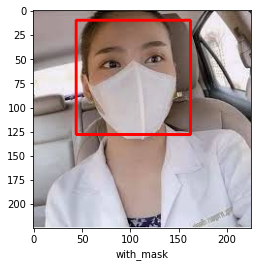

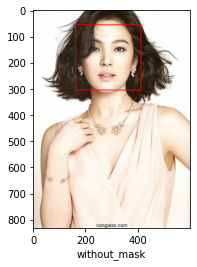

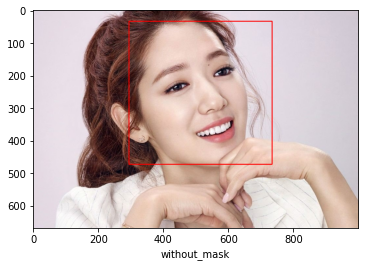

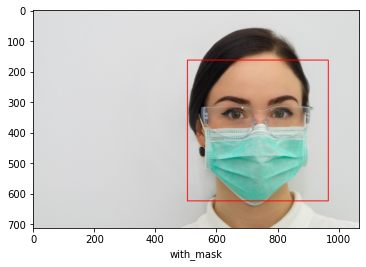

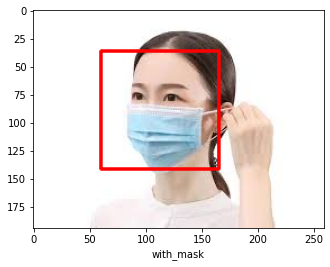

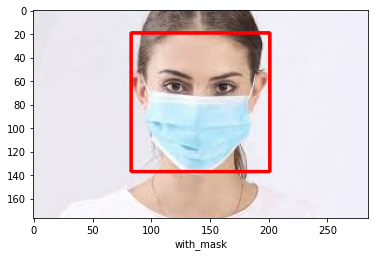

In [234]:
valid_folder = 'valid'
for file_name in os.listdir(valid_folder):
    test_path = os.path.join(valid_folder, file_name)

    test_image = cv2.imread(test_path)
    gray_test = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_test, 1.1, 4)

    if len(faces) == 0:
        l = predict_image(test_image)
    else:
        for (x, y, w, h) in faces:
            faces = test_image[y:y + h, x:x + w]
            # cv2.imwrite('face.jpg', faces)
            l = predict_image(faces)
            cv2.rectangle(test_image, (x, y), (x+w, y+h), (0, 0, 255), 2)

    rgb_img = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)

    plt.xlabel(CATEGORIES[int(l)])
    plt.show()